This project uses data related to the Electric Production from 1985 to 2017 and aims to develop ML algorithms for prediction and forecasting (SARIMA and LSTM)<br>
The notebook is organized as follows:<br>
- LSTM RNN :<br>
Data preparation for LSTM training : scaling, reshaping<br>
LSTM modeling<br>
LSTM Prediction<br>
LSTM Forecast<br>
 <br>
- SARIMA:<br>
Data preparation for SARIMA: stationarity analysis, PACF, ACF<br>
SARIMA modeling<br>
SARIMA Prediction<br>
SARIMA Forecast<br>

# *Prediction and Forecast comparison:*

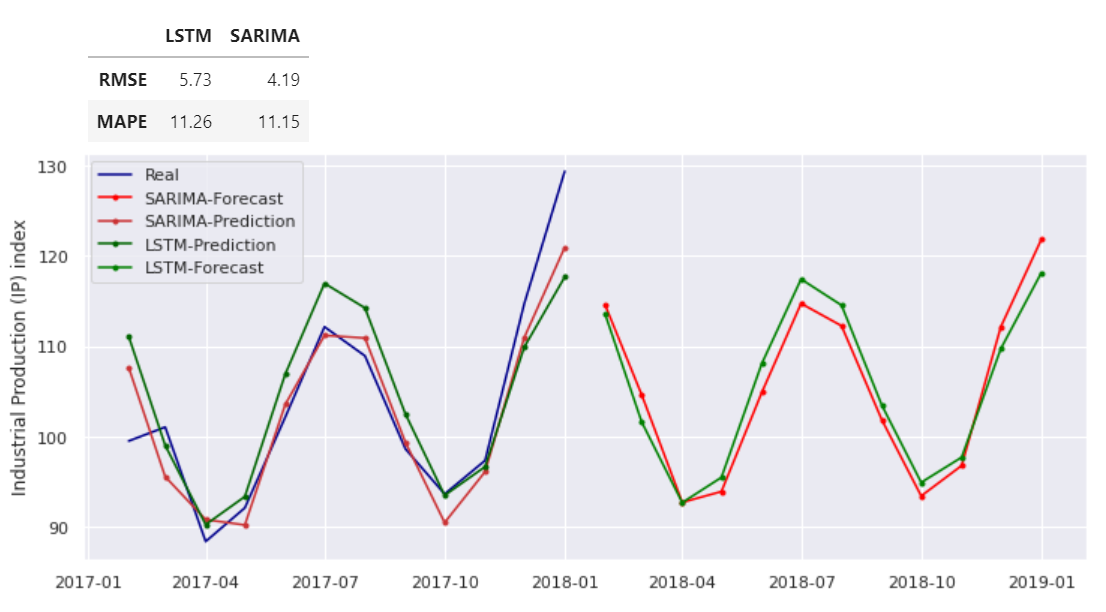

The results look indeed very similar both in terms of rmse and mape.

In [7]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/time-series-datasets/daily-minimum-temperatures-in-me.csv
/kaggle/input/time-series-datasets/sales-of-shampoo-over-a-three-ye.csv
/kaggle/input/time-series-datasets/Electric_Production.csv
/kaggle/input/time-series-datasets/monthly-beer-production-in-austr.csv


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt

sns.set_style('darkgrid')
sns.set_theme()
sns.set_palette("Set1", 8, .75)

In [9]:
df=pd.read_csv('/kaggle/input/time-series-datasets/Electric_Production.csv', index_col='DATE', parse_dates=True)

In [10]:
df.head()

,IPG2211A2N
DATE,
1985-01-01,72.5052
1985-02-01,70.6720
1985-03-01,62.4502
1985-04-01,57.4714
1985-05-01,55.3151


In [11]:
df.columns = ['value']

In [12]:
df.tail()

,value
DATE,
2017-09-01,98.6154
2017-10-01,93.6137
2017-11-01,97.3359
2017-12-01,114.7212
2018-01-01,129.4048


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 397 entries, 1985-01-01 to 2018-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   value   397 non-null    float64
dtypes: float64(1)
memory usage: 6.2 KB


There are no missing values!

<AxesSubplot:xlabel='DATE'>

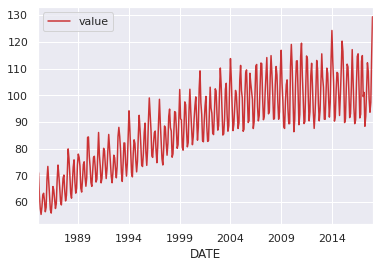

In [14]:
df.plot()

The data can be interpreted as a time series with a clear positive trend and seasonality.<br>
In the following, prediction models by LSTM RNN and SARIMAX will be developed to forecast the time series.

# LSTM RNN modeling


When modeling a time series by LSTM RNN, it is crucial to to properly shape the input data in a sliding windows format.

First, we need to specify the prediciton window. In this application, the data is given as monthly data. So, for example, we can use a 12 steps prediction window. This means that we use 12 samples of data (data of an entire year) to predict the 13th sample.

In [15]:
prediction_windows=12

Now we can split the data into a train and test set. In particular, this means that the train set will have 397-12=385 samples, while the test set only the last 12 values.

In [16]:
train=df.iloc[:len(df)-prediction_windows]
test=df.iloc[len(df)-prediction_windows:]

In the following, since we will use a RNN, it is recommended to rescale the data.

In [17]:
scaler=MinMaxScaler()

In [18]:
scaler.fit(df)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [19]:
n_input=12 #Use 12 months data to predict 13 th month data
n_features=1 # we are dealing with an univariate time series, so n_features should be set to 1. 
#In case of a multivariate time series, n_features should be set to a proper value higher than 1.

Now we can formally create the train set. As stated before, the train set will have a "sliding window" shape. This means that we have to shape the data in such a way that the RNN will predict the 13th sample starting from the previous from 12 samples.

In [20]:
X_train=[]
y_train=[]
for i in range(n_input,len(scaled_train)):
    X_train.append(scaled_train[i-n_input:i])
    y_train.append(scaled_train[i])
X_train, y_train = np.array(X_train), np.array(y_train)

In [21]:
print(f'Given the Array: \n {X_train[0].flatten()}')
print(f'Predict this value: \n {y_train[0]}')

Given the Array: 
 [0.23201741 0.20727443 0.09630353 0.02910391 0.         0.03745865
 0.09859805 0.10707831 0.07112325 0.0135012  0.03624525 0.18085375]
Predict this value: 
 [0.24282188]


In [22]:
# define model
model = Sequential()
model.add(LSTM(100, input_shape=(n_input, n_features), return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

2021-10-05 18:53:12.188541: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-10-05 18:53:12.191736: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-10-05 18:53:12.191771: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-10-05 18:53:12.191801: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (45e3e03e99e4): /proc/driver/nvidia/version does not exist
2021-10-05 18:53:12.192135: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operation

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 10)                1010      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 41,821
Trainable params: 41,821
Non-trainable params: 0
_________________________________________________________________


In [24]:
model.fit(X_train, y_train, epochs=200)

Epoch 1/200


2021-10-05 18:53:12.659223: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-10-05 18:53:12.669665: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2199995000 Hz


12/12 [==============================] - 2s 11ms/step - loss: 0.1531
Epoch 2/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0206
Epoch 3/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0165
Epoch 4/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0131
Epoch 5/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0150
Epoch 6/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0128
Epoch 7/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0130
Epoch 8/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0134
Epoch 9/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0130
Epoch 10/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0141
Epoch 11/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0127
Epoch 12/200
12/12 [==============================] - 0s 10ms/step - loss: 0.0121
Epoch 13/200
12/12 [=================

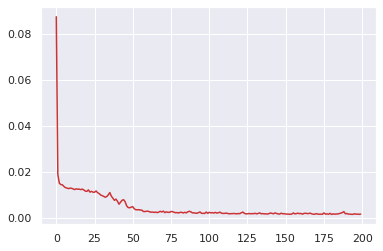

In [25]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

# LSTM Prediction

In [26]:
test_predictions = []

first_eval_batch = scaled_train[-n_input:] # use the previous 12 samples to predict the 13th
current_batch=first_eval_batch.reshape((1,n_input,n_features)) # reshape the data into (1,12,1)
for i in range(len(test)):
    #get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    test_predictions.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [27]:
true_predictions = scaler.inverse_transform(test_predictions)

In [28]:
test['Predictions'] = true_predictions

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='DATE'>

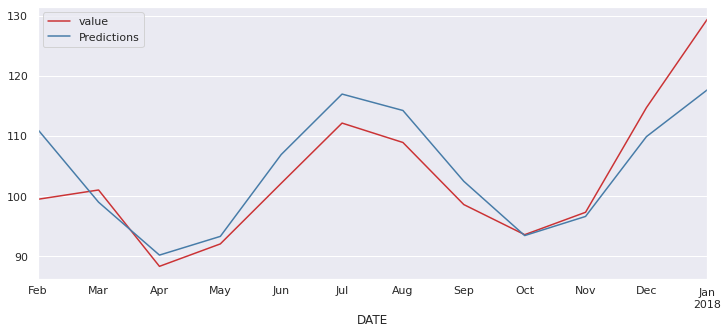

In [29]:
test.plot(figsize=(12,5))

In [30]:
rmse_lstm=sqrt(mean_squared_error(test['value'],test['Predictions']))
print(rmse_lstm)

5.7342332811357295


In [31]:
pred_dates=np.asarray(test.index)
dates=np.asarray(df.index)

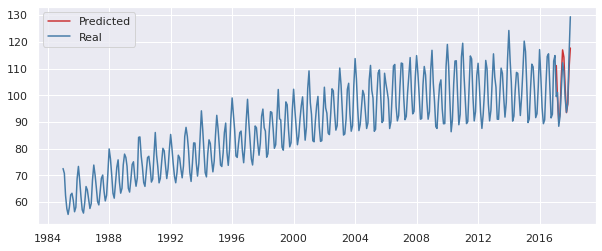

In [130]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,test['Predictions'].values,label='Predicted')
plt.plot(dates,df.values, label='Real')
plt.legend()
plt.show()

To check the performance of the algorithm, we will also define a MAPE (Mean absolute percentage error) function that returns the MAPE.

In [33]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [34]:
mape_lstm=mape(df.values[-12:], test['Predictions'].values)
mape_lstm

11.261019605218925

# LSTM Forecast

We can use the developed LSTM RNN to forecast the data. <br>
First, we need to create a new vector with the indeces of the forecast days. In this case, we choose to forecast the data for 12 months.

In [35]:
date_offset=12
forecast_dates =  (df.index + pd.DateOffset(months=date_offset))[-date_offset:]
forecast_dates

DatetimeIndex(['2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01',
               '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01',
               '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01'],
              dtype='datetime64[ns]', name='DATE', freq=None)

In [36]:
forecast=[]

first_eval_batch = test_predictions[-n_input:] #use the past 12 values of the predicted values to forecast
current_batch=np.reshape(first_eval_batch,(1,n_input,n_features))

for i in range(date_offset):
    #get the prediction alue for the first batch
    current_pred = model.predict(current_batch)[0]
    
    #append the prediction into the array
    forecast.append(current_pred)
    
    #use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]], axis=1)

In [37]:
true_forecast= scaler.inverse_transform(forecast)

In [38]:
df_forecast=pd.DataFrame({'date': forecast_dates})
df_forecast.set_index('date', inplace=True)
df_forecast['forecast']=true_forecast
df_forecast.head()

,forecast
date,
2018-02-01,113.532347
2018-03-01,101.585136
2018-04-01,92.663000
2018-05-01,95.457564
2018-06-01,108.107803


<AxesSubplot:xlabel='date'>

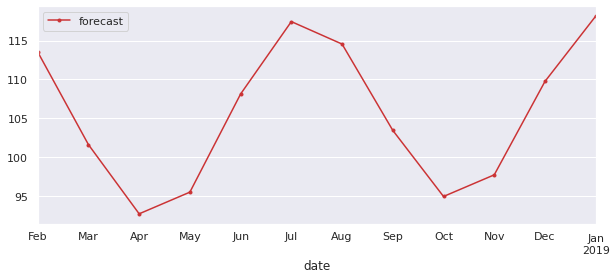

In [122]:
df_forecast.plot(figsize=(10,4), marker='.')

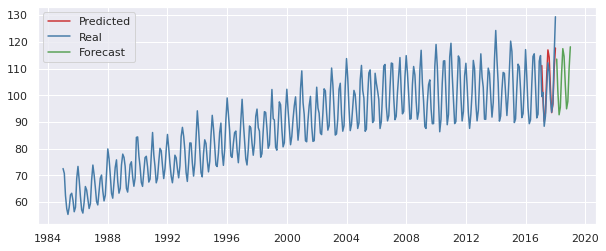

In [127]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,test['Predictions'].values,label='Predicted')
plt.plot(dates,df.values, label='Real')
plt.plot(forecast_dates,df_forecast['forecast'].values, label='Forecast')
plt.legend()
plt.show()

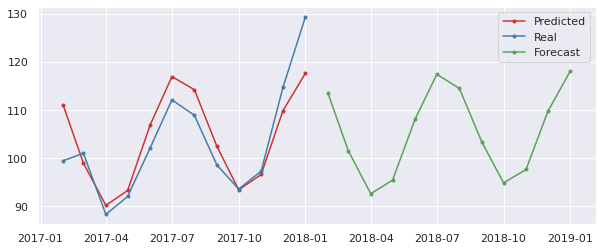

In [129]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,test['Predictions'].values, label='Predicted', marker='.')
plt.plot(dates[-12:],df[-12:].values, label='Real', marker='.')
plt.plot(forecast_dates,df_forecast['forecast'].values, label='Forecast', marker='.')
plt.legend()
plt.show()

# SARIMA modeling

In the following,the time series will be modeled by as a SARIMA model.

We can use some useful tools such as 'seasonal decompose' to better visualize the time series.

<Figure size 432x288 with 0 Axes>

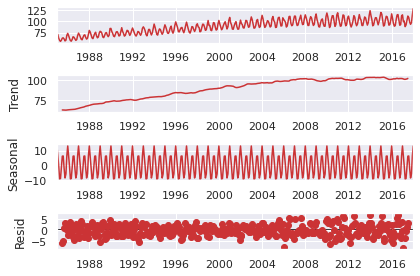

In [42]:
result = seasonal_decompose(df)

fig = plt.figure()  
fig = result.plot()

We can also check the stationarity of the time serie by performing the Augmented Dickey Fuller (ADF) test.

In [43]:
result=adfuller(df.value.dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-2.2569903500472366
p-value:0.18621469116587053


The p-value is higher than 0.05. This means that the time serie is non stationary with a confidence of 95%. We check if with a one step differentiation, the time serie become stationary (in terms of a trendless time series).

In [44]:
result=adfuller(df.value.diff().dropna())
print(f'ADF Statistics:{result[0]}')
print(f'p-value:{result[1]}')

ADF Statistics:-7.104890882267309
p-value:4.0777865655394705e-10


Now the series looks stationary with a 1-order difference

## ACF and PACF

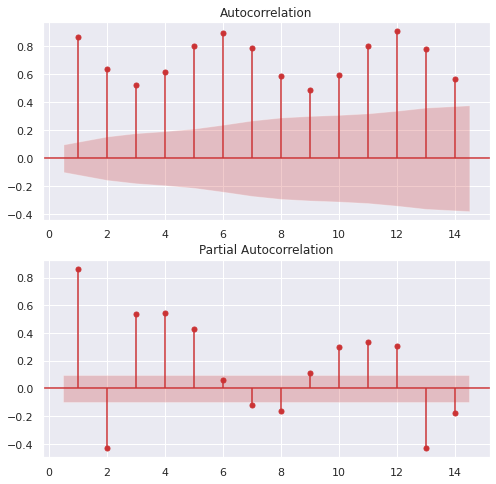

In [45]:
fig, (ax1, ax2)=plt.subplots(2,1,figsize=(8,8))

plot_acf(df,lags=14, zero=False, ax=ax1)
plot_pacf(df,lags=14, zero=False, ax=ax2)
plt.show()

The series looks indeed non stationary

## Auto ARIMA

In [46]:
!pip install pmdarima
import pmdarima as pm

     |████████████████████████████████| 1.4 MB 4.4 MB/s eta 0:00:01


In [47]:
results=pm.auto_arima(df, d=1, start_p=1, start_q=1, max_p=3, max_q=3,
                    seasonal=True, m=6, D=1, start_P=1, start_Q=1, max_P=2, max_Q=2, information_criterion='aic', trace=True, error_action='ignore', stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[6]             : AIC=1912.925, Time=0.85 sec
 ARIMA(0,1,0)(0,1,0)[6]             : AIC=2404.500, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[6]             : AIC=1998.731, Time=0.18 sec
 ARIMA(0,1,1)(0,1,1)[6]             : AIC=2057.803, Time=0.34 sec
 ARIMA(1,1,1)(0,1,1)[6]             : AIC=2000.250, Time=0.61 sec
 ARIMA(1,1,1)(1,1,0)[6]             : AIC=inf, Time=0.55 sec
 ARIMA(1,1,1)(2,1,1)[6]             : AIC=1880.044, Time=1.22 sec
 ARIMA(1,1,1)(2,1,0)[6]             : AIC=inf, Time=0.89 sec
 ARIMA(1,1,1)(2,1,2)[6]             : AIC=inf, Time=2.93 sec
 ARIMA(1,1,1)(1,1,2)[6]             : AIC=inf, Time=2.21 sec
 ARIMA(0,1,1)(2,1,1)[6]             : AIC=1925.181, Time=1.18 sec
 ARIMA(1,1,0)(2,1,1)[6]             : AIC=1942.791, Time=0.72 sec
 ARIMA(2,1,1)(2,1,1)[6]             : AIC=1881.313, Time=1.94 sec
 ARIMA(1,1,2)(2,1,1)[6]             : AIC=1880.682, Time=1.63 sec
 ARIMA(0,1,0)(2,1,1)[6]             : AIC=1955.485, T

In [48]:
model=SARIMAX(df,order=(2,1,2),  seasonal_order=(1, 1, 2, 6))
results=model.fit()

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.62107D+00    |proj g|=  1.35732D-01


/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
 This problem is unconstrained.



At iterate    5    f=  2.31439D+00    |proj g|=  2.99144D-02

At iterate   10    f=  2.28953D+00    |proj g|=  1.30022D-02

At iterate   15    f=  2.26953D+00    |proj g|=  3.67458D-02

At iterate   20    f=  2.26706D+00    |proj g|=  4.60416D-03

At iterate   25    f=  2.26588D+00    |proj g|=  1.02781D-02

At iterate   30    f=  2.26473D+00    |proj g|=  1.20999D-03

At iterate   35    f=  2.26471D+00    |proj g|=  5.25788D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    8     38     46      1     0     0   3.090D-05   2.265D+00
  F =   2.2647070235339561     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

In [49]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                             value   No. Observations:                  397
Model:             SARIMAX(2, 1, 2)x(1, 1, 2, 6)   Log Likelihood                -899.089
Date:                           Tue, 05 Oct 2021   AIC                           1814.177
Time:                                   18:55:11   BIC                           1845.907
Sample:                               01-01-1985   HQIC                          1826.755
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0873      0.350     -0.249      0.803      -0.773       0.599
ar.L2          0.2828      0.214      1.321      0.187      -0.137       0.702
ma.L1         -0.2982      0.337     -0.884      0.377      -0.959       0.363
ma.L2         -0.6397      0.329     -1.944      0.052      -1.285       0.005
ar.S.L6       -0.9976      0.003   -380.207      0.000      -1.003      -0.992
ma.S.L6        0.1145      0.040      2.832      0.005       0.035       0.194
ma.S.L12      -0.7764      0.037    -20.853      0.000      -0.849      -0.703
sigma2         5.5549      0.307     18.092      0.000       4.953       6.157
===================================================================================
Ljung-Box (L1) (Q):                   0.09   Jarque-Bera (JB):                42.26
Prob(Q):                              0.77   Prob(JB):                         0.00
Heteroskedasticity (H):               2.75   Skew:                            -0.17
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/opt/conda/lib/python3.7/site-packages/statsmodels/graphics/gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


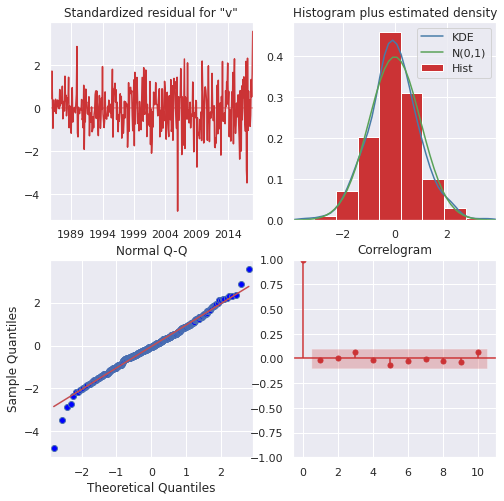

In [50]:
# Create the 4 diagostics plots
results.plot_diagnostics(figsize=(8,8))
plt.show()

All the 4 plots indicates a good fit of the SARIMA model on the given time serie.

# SARIMA Prediction

Now we will create a vector that will host the predictions

In [51]:
prediction = results.get_prediction(start=-12)
mean_prediction=prediction.predicted_mean

Moreover, we also get the confidence intervals from the sarima prediction

In [52]:
confi_int_p=prediction.conf_int()
lower_limits_p=confi_int_p.iloc[:,0]
upper_limits_p=confi_int_p.iloc[:,1]

In [53]:
pred_dates=np.asarray(mean_prediction.index)
dates=np.asarray(df.index)

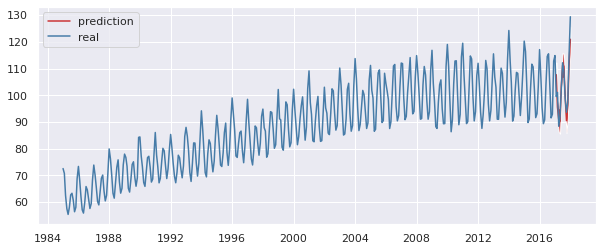

In [119]:
plt.figure(figsize=(10,4))
plt.plot(pred_dates,mean_prediction.values,label='prediction')
plt.fill_between(pred_dates, lower_limits_p, upper_limits_p)
plt.plot(dates,df.values, label='real')
plt.legend()
plt.show()

In [55]:
mape_sarima = mape(df[-12:].values,mean_prediction.values)

In [56]:
rmse_sarima = sqrt(mean_squared_error(df[-12:].values,mean_prediction.values))
print(rmse_sarima)

4.19325412021077


# SARIMA Forecast

In [57]:
# Make ARIMA forecast of next 10 values
forecast = results.get_forecast(steps=12)
mean_forecast=forecast.predicted_mean
mean_forecast.size

12

In [58]:
confi_int_f=forecast.conf_int()
lower_limits_f=confi_int_f.iloc[:,0]
upper_limits_f=confi_int_f.iloc[:,1]

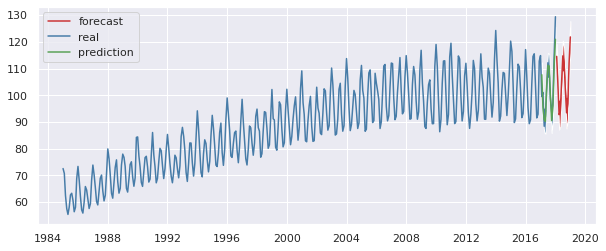

In [121]:
plt.figure(figsize=(10,4))
plt.plot(mean_forecast.index,mean_forecast.values,label='forecast')
plt.plot(dates,df.values, label='real')
plt.fill_between(mean_forecast.index, lower_limits_f, upper_limits_f)

plt.plot(mean_prediction.index, mean_prediction.values,label='prediction')
plt.fill_between(mean_prediction.index, lower_limits_p, upper_limits_p)

plt.legend(loc='upper left')
plt.show()

# Results Sumamry

In [ ]:
def get_scores(y, y_pred):
    data={'Accuracy': np.round(accuracy_score(y, y_pred),2),
    'Precision':np.round(precision_score(y, y_pred),2),
    'Recall':np.round(recall_score(y, y_pred),2),
    'F1':np.round(f1_score(y, y_pred),2),
    'ROC AUC':np.round(roc_auc_score(y, y_pred),2)}
    scores_df = pd.Series(data).to_frame('scores')
    return scores_df

In [113]:
lstm_scores=pd.Series({'RMSE':np.round(rmse_lstm,2), 'MAPE':np.round(mape_lstm,2)}).to_frame('LSTM')
sarima_scores=pd.Series({'RMSE':np.round(rmse_sarima,2), 'MAPE':np.round(mape_sarima,2)}).to_frame('SARIMA')

In [114]:
pd.concat([lstm_scores, sarima_scores], axis=1)

,LSTM,SARIMA
RMSE,5.73,4.19
MAPE,11.26,11.15


In [60]:
print('LSTM RMSE: ', np.round(rmse_lstm,2))
print('SARIMA RMSE: ', np.round(rmse_sarima,2))
print('LSTM MAPE: {} %'.format(np.round(mape_lstm,2)))
print('SARIMA MAPE: {} %'.format(np.round(mape_sarima,2)))

LSTM RMSE:  5.73
SARIMA RMSE:  4.19
LSTM MAPE: 11.26 %
SARIMA MAPE: 11.15 %


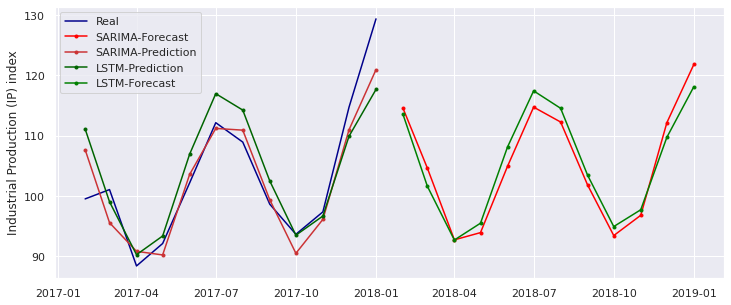

In [115]:
plt.figure(figsize=(12,5))
plt.plot(dates[-12:],df[-12:].values, color='darkblue', label='Real') 
plt.plot(mean_forecast.index, mean_forecast.values, color='red', label='SARIMA-Forecast', marker='.')
plt.plot(mean_prediction.index, mean_prediction.values, label='SARIMA-Prediction', marker='.')
plt.plot(mean_prediction.index, test['Predictions'].values, color='darkgreen',label='LSTM-Prediction', marker='.')
plt.plot(mean_forecast.index, df_forecast['forecast'].values, color='green',label='LSTM-Forecast', marker='.')
plt.legend(loc='upper left')
plt.ylabel('Industrial Production (IP) index')
plt.show()

We can see that SARIMA and LSTM obtained very similar results visually and in both terms of MAPE and RMSE.